In [2]:
# imports
from astropy.io import fits
from scipy import interpolate as sin
import matplotlib.pyplot as plt
# import matplotlib as mpl
import plotting as myP
import numpy as np
import csv 
import match

In [3]:
# path variables 
path_cat = 'D:\IfA REU\Catalogs'
path_fig = 'D:\IfA REU\IfA-REU-Project\Figures'
path_csv = 'D:\IfA REU\IfA-REU-Project\Lists'

# Read CSV

In [4]:
# read from a given csv file and return a list of its contents 
def ReadFile(filename) : 
    # initialize list
    file = []
    # open csv file
    with open(filename, newline='') as csv_file : 
        reader = csv.reader(csv_file, delimiter=',', quotechar='"')
        # output file into list for easy access
        for row in reader :
            file.append(row)
    # print column names 
    print(filename, '\tcolumns: ', file[0])
    # return an array of type int with column names clipped off
    return(file[1:])

In [5]:
# read AGN ID and index from csv files
agn_irSel20 = np.array(ReadFile(path_csv+'\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv'), dtype=int)
zMatch      = np.array(ReadFile(path_cat+'\COSMOS_z_matches.csv'))

D:\IfA REU\IfA-REU-Project\Lists\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv 	columns:  ['ID', 'i']
D:\IfA REU\Catalogs\COSMOS_z_matches.csv 	columns:  ['ID', 'z']


In [6]:
# transpose arrays to get columns
agn_irSel20_id, agn_irSel20_i = agn_irSel20.T
zMatch_id, zMatch_z = zMatch.T

# get correct data type
zMatch_id = np.array(zMatch_id, dtype=int)
zMatch_z  = np.array(zMatch_z,  dtype=float)

# Read Catalog

In [7]:
# open COSMOS 2020 catalog file and get data 
inf20 = fits.open(path_cat+'\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
# head20 = inf20[0].header
inf20.close()

In [8]:
# print(cols20)

# Get Data From Catalog 

In [189]:
# get photometry table values
flux_nu_uJy = np.array([   
        # The Galaxy Evolution Explorer (GALEX)
        np.array(data20['GALEX_FUV_FLUX']), 
        np.array(data20['GALEX_NUV_FLUX']),
        # Subaru / Hyper Suprime-Cam
        np.array(data20['HSC_g_FLUX_APER2']),
        np.array(data20['HSC_r_FLUX_APER2']),
        np.array(data20['HSC_i_FLUX_APER2']),
        np.array(data20['HSC_z_FLUX_APER2']),
        np.array(data20['HSC_y_FLUX_APER2']),
        # Paranal VISTA / VIRCAM
        np.array(data20['UVISTA_J_FLUX_APER2']),
        np.array(data20['UVISTA_H_FLUX_APER2']),
        np.array(data20['UVISTA_Ks_FLUX_APER2']),
        # Spitzer Large Area Survey with Hyper-Suprime-Cam (SPLASH) 
        np.array(data20['SPLASH_CH1_FLUX']),
        np.array(data20['SPLASH_CH2_FLUX']),
        np.array(data20['SPLASH_CH3_FLUX']),
        np.array(data20['SPLASH_CH4_FLUX']),
        # FIR
        np.array(data20['FIR_24_FLUX']),    # Spitzer/MIPS.24mu
        np.array(data20['FIR_100_FLUX']),   # Herschel/Pacs.green
        np.array(data20['FIR_160_FLUX']),   # Herschel/Pacs.red
        np.array(data20['FIR_250_FLUX']),   # Herschel/SPIRE.PSW
        np.array(data20['FIR_350_FLUX']),   # Herschel/SPIRE.PMW
        np.array(data20['FIR_500_FLUX'])    # Herschel/SPIRE.PLW
    ])  

# get photometry table values
flux_err_nu_uJy = np.array([   
        # The Galaxy Evolution Explorer (GALEX)
        np.array(data20['GALEX_FUV_FLUXERR']), 
        np.array(data20['GALEX_NUV_FLUXERR']),
        # Subaru / Hyper Suprime-Cam
        np.array(data20['HSC_g_FLUXERR_APER2']),
        np.array(data20['HSC_r_FLUXERR_APER2']),
        np.array(data20['HSC_i_FLUXERR_APER2']),
        np.array(data20['HSC_z_FLUXERR_APER2']),
        np.array(data20['HSC_y_FLUXERR_APER2']),
        # Paranal VISTA / VIRCAM
        np.array(data20['UVISTA_J_FLUXERR_APER2']),
        np.array(data20['UVISTA_H_FLUXERR_APER2']),
        np.array(data20['UVISTA_Ks_FLUXERR_APER2']),
        # Spitzer Large Area Survey with Hyper-Suprime-Cam (SPLASH) 
        np.array(data20['SPLASH_CH1_FLUXERR']),
        np.array(data20['SPLASH_CH2_FLUXERR']),
        np.array(data20['SPLASH_CH3_FLUXERR']),
        np.array(data20['SPLASH_CH4_FLUXERR']),
        # FIR
        np.array(data20['FIR_24_FLUXERR']),    # Spitzer/MIPS.24mu
        np.array(data20['FIR_100_FLUXERR']),   # Herschel/Pacs.green
        np.array(data20['FIR_160_FLUXERR']),   # Herschel/Pacs.red
        np.array(data20['FIR_250_FLUXERR']),   # Herschel/SPIRE.PSW
        np.array(data20['FIR_350_FLUXERR']),   # Herschel/SPIRE.PMW
        np.array(data20['FIR_500_FLUXERR'])    # Herschel/SPIRE.PLW
    ]) 

# transpose so [i] is a source, not a column
flux_nu_uJy = flux_nu_uJy.T
flux_err_nu_uJy = flux_err_nu_uJy.T

# change bad values to NaN
flux_nu_uJy = np.where(flux_nu_uJy <= float(0), float('nan'), flux_nu_uJy)
flux_nu_uJy = np.where(flux_err_nu_uJy/flux_nu_uJy >= 0.5, float('nan'), flux_nu_uJy) 

# print info
print('Table shape:', np.shape(flux_nu_uJy))

Table shape: (1720700, 20)


In [190]:
# list wavelengths of the photometry filters (in Angstroms)
# -- Used lambda_ref from: http://svo2.cab.inta-csic.es/theory/fps3/
lam_A = np.array([
          1535.08,      # 'GALEX_FUV_FLUX'
          2300.79,      # 'GALEX_NUV_FLUX'
          4798.21,      # 'HSC_g_FLUX_APER2'
          6218.44,      # 'HSC_r_FLUX_APER2'
          7727.02,      # 'HSC_i_FLUX_APER2'
          8908.50,      # 'HSC_z_FLUX_APER2'
          9775.07,      # 'HSC_y_FLUX_APER2'
         12524.83,      # 'UVISTA_J_FLUX_APER2'
         16432.40,      # 'UVISTA_H_FLUX_APER2'
         21521.52,      # 'UVISTA_Ks_FLUX_APER2'
         35378.41,      # 'SPLASH_CH1_FLUX' 
         44780.49,      # 'SPLASH_CH2_FLUX' 
         56961.77,      # 'SPLASH_CH3_FLUX' 
         77978.39,      # 'SPLASH_CH4_FLUX' 
        235934.61,      # 'FIR_24_FLUX'      
             1.01e+6,   # 'FIR_100_FLUX'
             1.62e+6,   # 'FIR_160_FLUX'
             2.48e+6,   # 'FIR_250_FLUX'
             3.48e+6,   # 'FIR_350_FLUX'
             5.00e+6    # 'FIR_500_FLUX'
    ])

# print info 
print('Number of Filters: ', len(lam_A))

Number of Filters:  20


# Refine Data

In [191]:
# get mask of valid redshifts
mask_z = (zMatch_z >= 0) & (zMatch_z < 99)

# apply mask to remove -99 redshifts
zValid_id = zMatch_id[mask_z]
zValid_z  = zMatch_z[mask_z]

# print info
print('number of sources in z matches:\t',  len(zMatch_id))
print('Number of sources with z:\t',        len(zValid_id))

number of sources in z matches:	 865086
Number of sources with z:	 485793


In [192]:
# match redshifts to agn
key_z, key_agn = match.match(zValid_id, agn_irSel20_id)

# apply key to get parallel lists if agn-z matches
z_id    = zValid_id[key_z]
z_z     = zValid_z[key_z]
agn_id  = agn_irSel20_id[key_agn]
agn_i   = agn_irSel20_i[key_agn]

# get flux table of agn sources 
agn_flux_nu_uJy = flux_nu_uJy[agn_i]

# print info
print('Table shape:', np.shape(agn_flux_nu_uJy))


Table shape: (1533, 20)


In [193]:
# initialize table of rest frame wavelengths
lamR_A = np.zeros(agn_flux_nu_uJy.shape)

# get rest wavelength 
for i,z in enumerate(z_z) : 
    # lambda_rest = lambda_observed / (1+z)
    lamR_A[i] = lam_A / (1+z)

# Convert Units

In [194]:
# convert wavelength units
lamR_cm = lamR_A * 1E-8
lamR_um = lamR_A * 1E-4
lam_um  = lam_A  * 1E-4

In [195]:
# speed of light (constant)
c_cm = 2.99792458 * 1E10 # cm/s

# c/lambda^2
c_lamR2 = c_cm / lamR_cm**2

In [196]:
# convert Jy to cgs units: # 1 Jy = 10^-23 erg/s/cm2/Hz, uJy = 10^-6 Jy
agn_flux_nu_ergscm2Hz = agn_flux_nu_uJy * 1E-23 * 1E-6

# multiply F_nu by c/lam^2 to get F_lam
agn_flux_lam_ergscm3 = np.multiply(agn_flux_nu_ergscm2Hz, c_lamR2)

# lam * F_lam [erg/s/cm]
agn_lamflux_lam_ergscm2 = np.multiply(agn_flux_lam_ergscm3, lamR_cm)

# verify same shape 
print('Table shape:', np.shape(agn_lamflux_lam_ergscm2))

Table shape: (1533, 20)


# Make SED

In [197]:
# initialize list 
agn_lamflux_lam_ergscm2_NORM = []
# get shape 
numRow, numCol = lamR_um.shape

# normalize each agn source in log space 
for row in range(numRow) :
    # get x and y
    x = lamR_um[row]
    y = agn_lamflux_lam_ergscm2[row]
    # get log scale and exclude NaN
    logx = np.log10(x[~np.isnan(y)])
    logy = np.log10(y[~np.isnan(y)])
    # interpolate flux curve 
    f = sin.interp1d(logx, logy, kind='linear', fill_value='extrapolate')
    # normalize
    at1um = 10**f(np.log10(1))
    agn_lamflux_lam_ergscm2_NORM.append( y / at1um )

# convert list to array 
agn_lamflux_lam_ergscm2_NORM = np.array(agn_lamflux_lam_ergscm2_NORM)

# verify same shape 
print('Table shape:', np.shape(agn_lamflux_lam_ergscm2_NORM))


Table shape: (1533, 20)


In [198]:
# set standard plot format
myP.SetStyle()

In [199]:
def PlotSED(x,y,num,title='',offset=0) : 
    
    # plot SED curves
    for i in range(num) : 
        plt.plot(x[i+offset],y[i+offset])
        # plt.plot(x[i+offset],y[i+offset],'x',c='k')

    # axis
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1E-1, 1E+3)
    # plt.ylim(1E-3, 1E+2)

    # set lables 
    plt.xlabel('$\lambda_{rest} \; [\mu m]$') 
    plt.ylabel('$Normalized \; \lambda F_{\lambda} \; [erg \; s^{-1} \; cm^{-2}]$')

    # set title
    if(title!='') : 
        plt.title(title)

    # show plot
    plt.show()

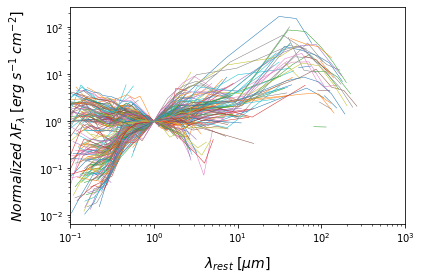

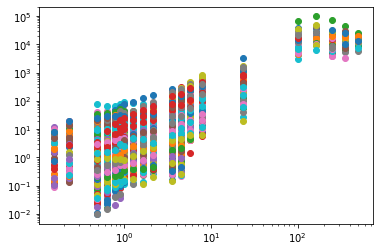

In [209]:
# plot some sources 
x = lamR_um
y = agn_lamflux_lam_ergscm2_NORM
PlotSED(x,y,num=200)

for row in range(200) : 
    x = lam_um
    y = agn_flux_nu_uJy[row]
    plt.plot(x,y,'o')
    plt.yscale('log')
    plt.xscale('log')

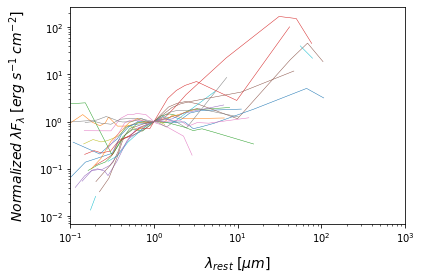

[        nan   0.2311383   0.2704538   0.530958    0.9071662   1.4753337
   2.0215514   3.001702    4.073459    5.917489   12.446148   13.546209
  23.604649   36.57506   118.84401           nan         nan         nan
         nan         nan]
min:  0.2311383
minI: 1
ID:  100728
[ 0.41369793  0.35488456  1.7788968   1.59394     1.6625465   2.1967833
  3.2146554   2.645956    3.492509    5.3191085   9.383475   11.410902
 20.688864   23.653723   74.1471             nan         nan         nan
         nan         nan]
min:  0.35488456
minI: 1
ID:  110707
[          nan           nan 1.4506663e-01 2.4398069e-01 3.5335743e-01
 5.1995295e-01 7.1003503e-01 1.9847411e+00 3.6819000e+00 4.4510183e+00
 1.5244574e+01 2.1348341e+01 2.4874697e+01 4.4517738e+01 1.5377899e+02
           nan           nan           nan           nan           nan]
min:  0.14506663
minI: 2
ID:  123228
[          nan           nan 8.5450940e-02 1.3310815e-01 1.4707546e-01
 1.8106344e-01 2.0406026e-01 4.5977905e-01 7.092

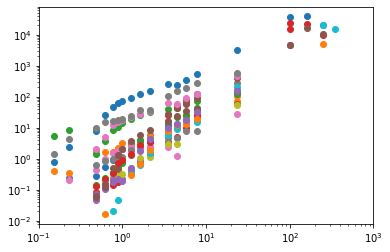

In [210]:
bad = [44,45,48,50,52,57,59,60,62,64,70,72,75,77,78,79,83,95]
s=18
o=0

# plot some sources 
x = lamR_um[bad]
y = agn_lamflux_lam_ergscm2_NORM[bad]
PlotSED(x,y,num=s,offset=o)

yy = agn_flux_nu_uJy[bad]
for row in range(s) : 
    x = lam_um
    y = yy[row+o]
    plt.plot(x,y,'o')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1E-1, 1E+3)
    # plt.ylim(1E-3, 1E+2)
    # plt.show()

    print(y)
    # print('max: ',np.nanmax(y))
    print('min: ',np.nanmin(y))
    print('minI:',np.nanargmin(y))
    print('ID: ', agn_id[row])
    # print(y[np.nanargmin(y)])

In [204]:
hm = [
    [0.000964, 19],
    [0.01869448, 15],
    [0.000959, 17],
    [0.0009806, 18],
    [4.0827e-07, 14],
    [1.66915003e-02, 15],
    [1.61572006e-02, 16],
    [0.000964, 19],
    [9.8060002e-04, 18],
    [0.0166915, 15],
    [0.018096065, 16],
    [1.6691500e-02, 15],
    [1.6157201e-02, 16],
    [9.5900003e-04, 17],
    [9.6400001e-04, 19],
    [9.6400001e-04, 19],
    [9.80600016e-04, 18]
]

In [205]:
# why are some sources very far left on the plot? 
# skip misbehaving sources? or sources with not enough data? 

# reduce data by redshift range

# TODO next -- make nice plots for paper 

# Sort SED by Redshift 

Min:	 0.0
Max:	 6.3381


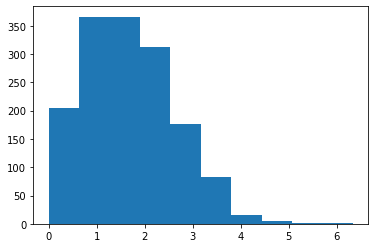

In [206]:
print('Min:\t', min(z_z))
print('Max:\t', max(z_z))
plt.hist(z_z)
plt.show()

In [207]:
bin_z = np.array([
    (z_z > 0.0) & (z_z <= 0.5),
    (z_z > 0.5) & (z_z <= 1.0),
    (z_z > 1.0) & (z_z <= 1.5),
    (z_z > 1.5) & (z_z <= 2.0),
    (z_z > 2.0) & (z_z <= 2.5),
    (z_z > 2.5) & (z_z <= 3.0),
    (z_z > 3.0) & (z_z <= 3.5),
    (z_z > 3.5) & (z_z <= 4.0),
    (z_z > 4.0)
])

bin_z_title = np.array([
    '0.0-0.5',
    '0.5-1.0',
    '1.0-1.5',
    '1.5-2.0',
    '2.0-2.5',
    '2.5-3.0',
    '3.0-3.5',
    '3.5-4.0',
    '>4.0'
])

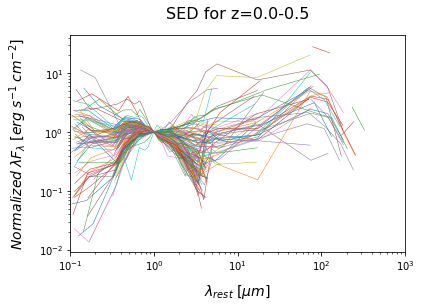

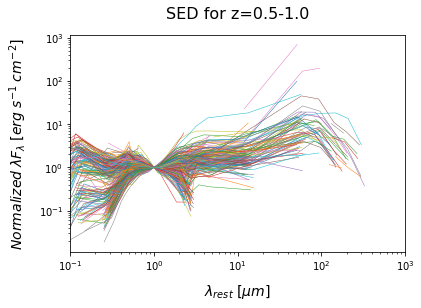

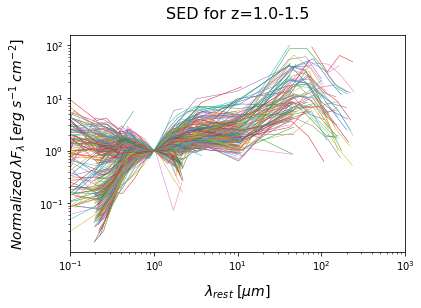

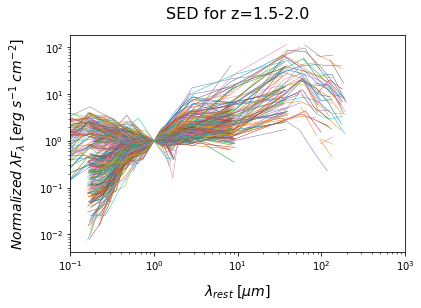

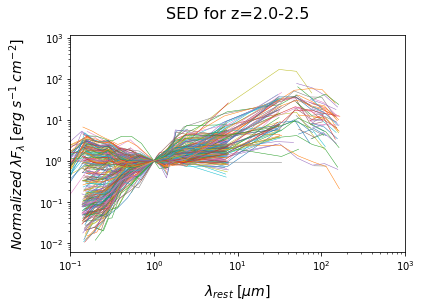

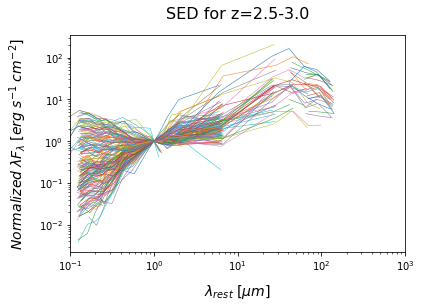

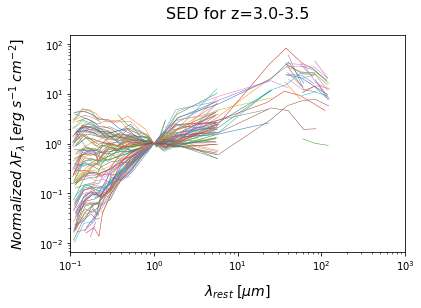

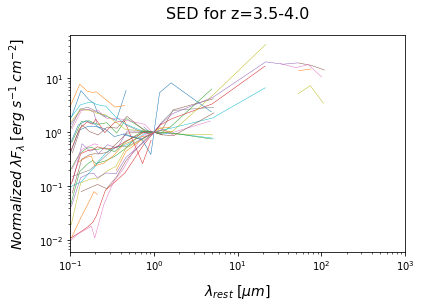

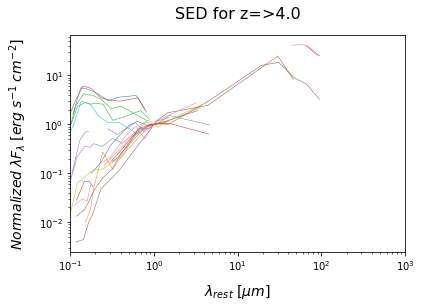

In [208]:
for i,z in enumerate(bin_z) :
    x = lamR_um[z]
    y = agn_lamflux_lam_ergscm2_NORM[z]
    r,c = np.shape(x)
    t = bin_z_title[i]
    PlotSED(x,y,r,title='SED for z='+t)

* fix far ir
* tidy up plot axis range
* add n=#
* get nice colors
* clean up other plots for paper 

plt.grid()